In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
'''c0: safe driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger'''

#Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Input, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

In [4]:
df = pd.read_csv('./driver_imgs_list.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [6]:
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


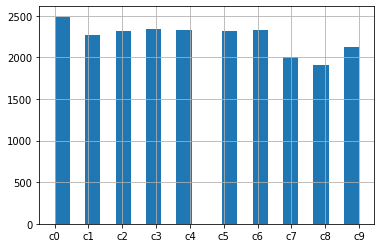

In [7]:
df['classname'].hist(bins = 20)

#Preparing Data

In [8]:
train_dir = './imgs/train/'
img_size = 224
batch_size = 64
num_classes = 10

In [9]:
datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3, 
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [10]:
train_ds = datagen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    shuffle = True,
    target_size = (img_size,img_size),
    subset='training',
    batch_size = batch_size,
    seed = 127
)
val_ds = train_ds = datagen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    target_size = (img_size,img_size),
    subset='validation',
    batch_size = batch_size,
    seed = 127
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


#Building Model

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), padding='same',kernel_initializer='he_normal',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, kernel_initializer='he_normal', kernel_regularizer='l2', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_initializer='he_normal', kernel_regularizer='l2', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0

##Transfer learning

In [ ]:
base_modelI = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base_modelI.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
model_InceptionV3 = tf.keras.Model(inputs = base_modelI.input, outputs = predictions)
model_InceptionV3.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [11]:
base_modelD = tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base_modelD.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
model_DenseNet121 = tf.keras.Model(inputs = base_modelD.input, outputs = predictions)
model_DenseNet121.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

#Training and Evaluating Model

##Model 1

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mcp = tf.keras.callbacks.ModelCheckpoint('./model1.h5',monitor='val_accuracy',save_weights_only=True,mode='max',save_best_only=True )
model.fit(train_ds, validation_data=val_ds,
          steps_per_epoch = train_ds.n//batch_size,
          validation_steps = val_ds.n//batch_size,
          epochs = 60, verbose = 1,callbacks = [mcp])

Epoch 1/60
70/70 [==============================] - 1400s 19s/step - loss: 11.7434 - accuracy: 0.0973 - val_loss: 7.2476 - val_accuracy: 0.1109
Epoch 2/60
70/70 [==============================] - 133s 2s/step - loss: 6.4633 - accuracy: 0.1215 - val_loss: 4.7437 - val_accuracy: 0.1312
Epoch 3/60
70/70 [==============================] - 133s 2s/step - loss: 4.3340 - accuracy: 0.1572 - val_loss: 3.5232 - val_accuracy: 0.1855
Epoch 4/60
70/70 [==============================] - 134s 2s/step - loss: 3.2860 - accuracy: 0.1825 - val_loss: 2.8087 - val_accuracy: 0.2196
Epoch 5/60
70/70 [==============================] - 134s 2s/step - loss: 2.7284 - accuracy: 0.2162 - val_loss: 2.5868 - val_accuracy: 0.2027
Epoch 6/60
70/70 [==============================] - 134s 2s/step - loss: 2.4271 - accuracy: 0.2229 - val_loss: 2.2742 - val_accuracy: 0.2605
Epoch 7/60
70/70 [==============================] - 136s 2s/step - loss: 2.2021 - accuracy: 0.2821 - val_loss: 2.2387 - val_accuracy: 0.2400
Epoch 8/60

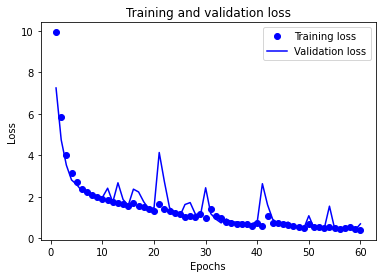

In [ ]:
history =model.history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

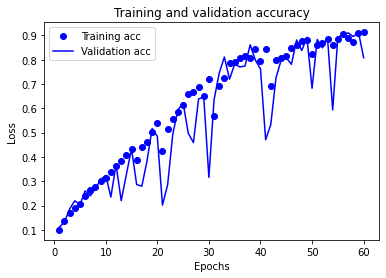

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save('model1.h5')

##Inception model

In [ ]:

base_modelI.trainable = False
mcp = tf.keras.callbacks.ModelCheckpoint("Inception.h5", monitor="val_accuracy",
                  save_best_only=True, mode='max', save_weights_only=True, verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, mode='max', patience=5, min_lr=1e-8, verbose=1)

# Compile model
model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.load_weights("efficientnetb3.h5")

# Huấn luyện 10 epochs với learning rate lớn
model_InceptionV3.fit(train_ds, validation_data=val_ds,
          steps_per_epoch = train_ds.n//batch_size,
          validation_steps = val_ds.n//batch_size,
          epochs = 10, verbose = 1, callbacks = [mcp,rlr])

# Unfreeze toàn bộ mạng
base_modelI.trainable = True

# Compile model
model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy',
              metrics=['accuracy'])


model_InceptionV3.fit(train_ds, validation_data=val_ds,
          steps_per_epoch = train_ds.n//batch_size,
          validation_steps = val_ds.n//batch_size,
          epochs = 60, verbose = 1, callbacks = [mcp])


Epoch 1/10
70/70 [==============================] - 138s 2s/step - loss: 5.0116 - accuracy: 0.3509 - val_loss: 2.0732 - val_accuracy: 0.4109

Epoch 00001: val_accuracy improved from -inf to 0.41094, saving model to Inception.h5
Epoch 2/10
70/70 [==============================] - 134s 2s/step - loss: 1.8669 - accuracy: 0.4759 - val_loss: 1.4508 - val_accuracy: 0.5437

Epoch 00002: val_accuracy improved from 0.41094 to 0.54375, saving model to Inception.h5
Epoch 3/10
70/70 [==============================] - 134s 2s/step - loss: 1.9998 - accuracy: 0.4797 - val_loss: 1.8641 - val_accuracy: 0.4967

Epoch 00003: val_accuracy did not improve from 0.54375
Epoch 4/10
70/70 [==============================] - 133s 2s/step - loss: 1.8691 - accuracy: 0.4972 - val_loss: 1.6326 - val_accuracy: 0.5435

Epoch 00004: val_accuracy did not improve from 0.54375
Epoch 5/10
70/70 [==============================] - 133s 2s/step - loss: 3.2912 - accuracy: 0.4614 - val_loss: 2.1790 - val_accuracy: 0.5446

Epoch

In [ ]:
model.save('model_InceptionV3.h5')

In [ ]:
history = model_InceptionV3.history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fg, ax = plt.subplots(1, 2, figsize=(20, 14))

ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')
plt.legend()
plt.show()

##Dense model

In [12]:
base_modelD.trainable = False
mcp = tf.keras.callbacks.ModelCheckpoint("DenseNet121.h5", monitor="val_accuracy",
                  save_best_only=True, mode='max', save_weights_only=True, verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, mode='max', 
                                           patience=5, min_lr=1e-8, verbose=1)
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=10, verbose=0,
)
model_DenseNet121.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy',
              metrics=['accuracy'])


model_DenseNet121.fit(train_ds, validation_data=val_ds,
          steps_per_epoch = train_ds.n//batch_size,
          validation_steps = val_ds.n//batch_size,
          epochs = 10, verbose = 1, callbacks = [mcp,rlr])

base_modelD.trainable = True

model_DenseNet121.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

model_DenseNet121.fit(train_ds, validation_data=val_ds,
          steps_per_epoch = train_ds.n//batch_size,
          validation_steps = val_ds.n//batch_size,
          epochs = 60, verbose = 1, callbacks = [mcp,stop])

Epoch 1/10
70/70 [==============================] - 2746s 39s/step - loss: 2.4954 - accuracy: 0.2803 - val_loss: 1.5502 - val_accuracy: 0.4857

Epoch 00001: val_accuracy improved from -inf to 0.48571, saving model to DenseNet121.h5
Epoch 2/10
70/70 [==============================] - 166s 2s/step - loss: 1.4579 - accuracy: 0.5087 - val_loss: 1.8341 - val_accuracy: 0.5076

Epoch 00002: val_accuracy improved from 0.48571 to 0.50759, saving model to DenseNet121.h5
Epoch 3/10
70/70 [==============================] - 167s 2s/step - loss: 1.3036 - accuracy: 0.5744 - val_loss: 1.8010 - val_accuracy: 0.4576

Epoch 00003: val_accuracy did not improve from 0.50759
Epoch 4/10
70/70 [==============================] - 166s 2s/step - loss: 1.3095 - accuracy: 0.5873 - val_loss: 0.9875 - val_accuracy: 0.6562

Epoch 00004: val_accuracy improved from 0.50759 to 0.65625, saving model to DenseNet121.h5
Epoch 5/10
70/70 [==============================] - 163s 2s/step - loss: 1.0300 - accuracy: 0.6468 - val_

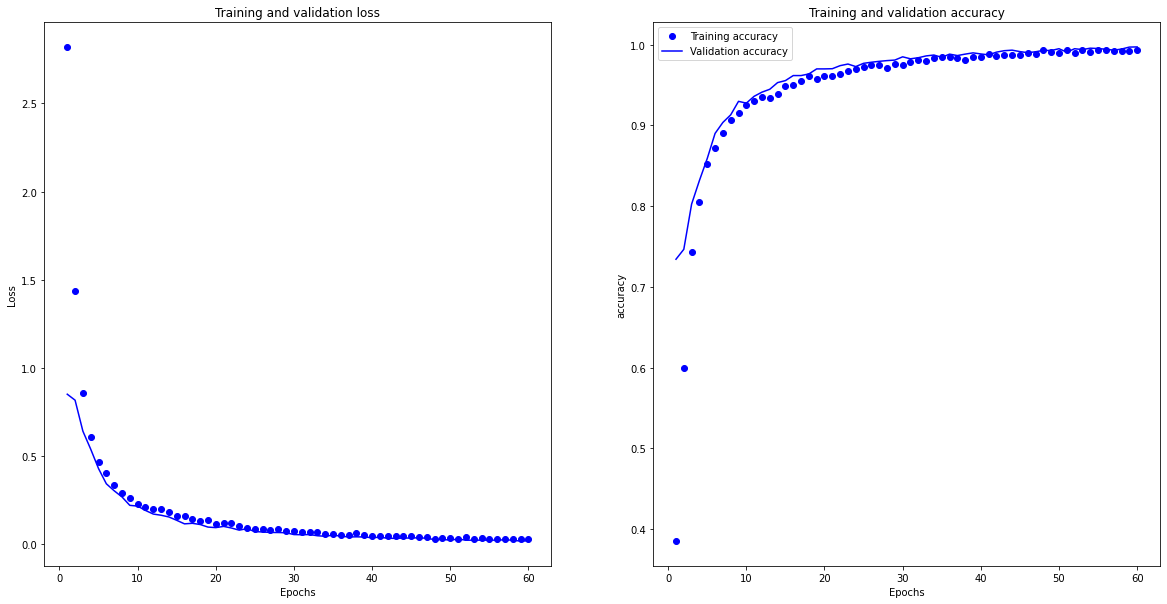

In [14]:
history = model_DenseNet121.history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fg, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')
plt.legend()
plt.show()

In [15]:
model_DenseNet121.save('model_DenseNet121.h5')

In [16]:
model = tf.keras.models.load_model('model_DenseNet121.h5')

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________